## Parsing and Plotting QC Algorithm Results and Annotations
* #### This notebook refers to evidence of biofouling of Global Dissolved Oxygen sensors

*Written by Friedrich Knuth, Rutgers University*

*Revised by Lori Garzio (to work with Pangeo), Rutgers University, July 9, 2018*

*Revised by Leila Belabbassi (to work with GitHub for plots display), Rutgers University, Aug 8 2018*   



In this example we will learn how to programatically download OOI JSON data and work with the QC algorithm results as well as annotations. We will use data from the Global Irminger Sea Apex Surface Mooring - Near Surface Instrument Frame - Dissolved Oxygen for this example, but the mechanics apply to all datasets that are processed through the OOI Cyberinfrastructure (CI) system. You wil learn:

* how to find the data you are looking for
* how to use the machine to machine API to request JSON data
* how to explore and interactively plot data using bokeh
* how to parse and visualize QC results
* how to parse and visualize Annotations

For the instrument in this example, you will need the Reference Designator, Stream and Data Delivery Method to make the request to the M2M API. More information about the instrument can be found here:
http://ooi.visualocean.net/instruments/view/GI01SUMO-RID16-06-DOSTAD000

![GI01SUMO-RID16-06-DOSTAD000](https://github.com/ooi-data-review/ooi_datateam_notebooks/raw/master/images/GI01SUMO-RID16-06-DOSTAD000.png)

In [4]:
import requests
import datetime

Before we get started, login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner).

In [7]:
username = ''
token = ''

Specify your inputs.

In [8]:
subsite = 'GI01SUMO'
node = 'RID16'
sensor = '06-DOSTAD000'
method = 'recovered_host'
stream = 'dosta_abcdjm_dcl_instrument_recovered'
beginDT = '2015-09-01T01:01:01.900Z'
endDT = '2016-03-01T01:01:01.900Z'

Build the data request URL.

In [9]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,
    'limit':1000,   
}

#### Note: Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

Uncomment the lines and send the data request.

In [10]:
#r = requests.get(data_request_url, params=params,auth=(username, token))
#data = r.json()

In [11]:
# How many data points were returned?
len(data)

1001

In [12]:
# Examine the contents of the first data point.
data[0]

{u'blue_amplitude': 874.4000244140625,
 u'blue_phase': 40.797000885009766,
 u'calibrated_phase': 32.02000045776367,
 u'ctdbp_cdef_dcl_instrument_recovered-practical_salinity': 34.82982019849851,
 u'ctdbp_cdef_dcl_instrument_recovered-temp': 8.668100357055664,
 u'dcl_controller_timestamp': u'empty',
 u'dissolved_oxygen': 280.9423869566828,
 u'dissolved_oxygen_qc_executed': 29,
 u'dissolved_oxygen_qc_results': 29,
 u'dosta_abcdjm_cspp_tc_oxygen': 360.9918912818415,
 u'dosta_abcdjm_cspp_tc_oxygen_qc_executed': 13,
 u'dosta_abcdjm_cspp_tc_oxygen_qc_results': 13,
 u'driver_timestamp': 3718195882.4196177,
 u'estimated_oxygen_concentration': 365.4200134277344,
 u'estimated_oxygen_concentration_qc_executed': 9,
 u'estimated_oxygen_concentration_qc_results': 9,
 u'estimated_oxygen_saturation': 99.99099731445312,
 u'estimated_oxygen_saturation_qc_executed': 1,
 u'estimated_oxygen_saturation_qc_results': 1,
 u'ingestion_timestamp': 3718195887.715,
 u'internal_timestamp': 0.0,
 u'optode_temperatur

Convert the json response to a pandas dataframe and convert the time stamps.

In [13]:
import pandas as pd
import numpy as np
import json

In [14]:
df = pd.DataFrame.from_records(map(json.loads, map(json.dumps,data)))
df['time'] = pd.to_datetime(df['time'], unit='s', origin=pd.Timestamp('1900-01-01'))

Extract the dissolved oxygen parameter for plotting.

In [15]:
time = list(df['time'].values)
oxygen = list(df['dissolved_oxygen'].values)

Plot the data.

In [58]:
from matplotlib import pyplot as plt 
import seaborn as sns # package for nice plotting defaults
sns.set()

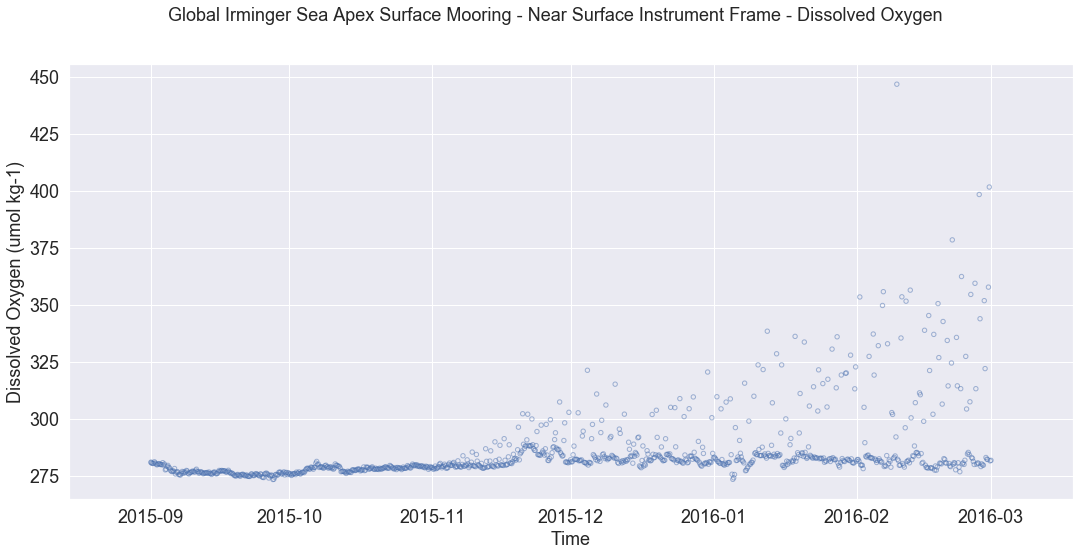

In [18]:
fig, axarr = plt.subplots(figsize=(18,8))

axarr.scatter(time, oxygen, marker='o', alpha=0.5, s=19, facecolors='none', edgecolors='b')
             
fig.suptitle('Global Irminger Sea Apex Surface Mooring - Near Surface Instrument Frame - Dissolved Oxygen', fontsize=18)
axarr.set_ylabel('Dissolved Oxygen (umol kg-1)', fontsize = 18)
axarr.set_xlabel('Time', fontsize = 18)
plt.setp(axarr.yaxis.get_majorticklabels(), size = 18)
plt.setp(axarr.xaxis.get_majorticklabels(), size = 18);


Extract only the qc results.

In [19]:
df = df[['time', 'dissolved_oxygen','dissolved_oxygen_qc_results','dissolved_oxygen_qc_executed']]
df.head()

,time,dissolved_oxygen,dissolved_oxygen_qc_results,dissolved_oxygen_qc_executed
0,2015-09-01 01:01:00.025,280.942387,29,29
1,2015-09-01 01:01:02.025,280.709263,29,29
2,2015-09-01 05:18:02.060,280.461004,29,29
3,2015-09-01 09:45:41.533,280.345899,29,29
4,2015-09-01 14:03:01.415,280.418900,29,29


The QC flags for all tests are OR'd together to produce a single value for each data point. So, given a qc_executed value of 29 we can see which tests were run by reversing the process:  

QC table
```
Test name              Bit position
                         15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0
global_range_test         0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
dataqc_localrangetest     0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
dataqc_spiketest          0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
dataqc_polytrendtest      0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
dataqc_stuckvaluetest     0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
dataqc_gradienttest       0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
dataqc_propagateflags     0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
```



In [20]:
np.unpackbits(np.array(29).astype('uint8'))

array([0, 0, 0, 1, 1, 1, 0, 1], dtype=uint8)

If you compare this result to the table above you can see that the following tests were executed:

```
global_range_test
dataqc_spiketest
dataqc_polytrendtest
dataqc_stuckvaluetest
```

We can craft a function to create new booleans variables for each test run containing the pass/fail results from that test:

In [21]:
def parse_qc(df):
    vars = [x.split('_qc_results')[0] for x in df.columns if 'qc_results' in x]
    results = [x+'_qc_results' for x in vars]
    executed = [x+'_qc_executed' for x in vars]
    key_list = vars + results + executed

    for var in vars:
        qc_result = var + '_qc_results'
        qc_executed = var + '_qc_executed'
        names = {
            0: var + '_global_range_test',
            1: var + '_dataqc_localrangetest',
            2: var + '_dataqc_spiketest',
            3: var + '_dataqc_polytrendtest',
            4: var + '_dataqc_stuckvaluetest',
            5: var + '_dataqc_gradienttest',
            7: var + '_dataqc_propagateflags',
        }
        # Just in case a different set of tests were run on some datapoint. *This should never happen*
        executed = np.bitwise_or.reduce(df[qc_executed].values)
        executed_bits = np.unpackbits(executed.astype('uint8'))
        for index, value in enumerate(executed_bits[::-1]):
            if value:
                name = names.get(index)
                mask = 2 ** index
                values = (df[qc_result].values & mask) > 0
                df[name] = values
        df.drop([qc_executed, qc_result], axis=1, inplace=True)
    return df

Run the function. The result gives us the QC algorithm result for every data point. True = test passed.

In [22]:
df_qc = parse_qc(df)
df_qc.head()

,time,dissolved_oxygen,dissolved_oxygen_global_range_test,dissolved_oxygen_dataqc_spiketest,dissolved_oxygen_dataqc_polytrendtest,dissolved_oxygen_dataqc_stuckvaluetest
0,2015-09-01 01:01:00.025,280.942387,True,True,True,True
1,2015-09-01 01:01:02.025,280.709263,True,True,True,True
2,2015-09-01 05:18:02.060,280.461004,True,True,True,True
3,2015-09-01 09:45:41.533,280.345899,True,True,True,True
4,2015-09-01 14:03:01.415,280.418900,True,True,True,True


Select data points that failed the global range test, for example.

In [23]:
df_qc[df_qc['dissolved_oxygen_global_range_test'] == False]

,time,dissolved_oxygen,dissolved_oxygen_global_range_test,dissolved_oxygen_dataqc_spiketest,dissolved_oxygen_dataqc_polytrendtest,dissolved_oxygen_dataqc_stuckvaluetest
888,2016-02-09 15:18:01.063,446.684005,False,True,True,True
998,2016-02-29 16:16:19.688,401.589245,False,True,True,True


Plot points that failed the test in red.

In [24]:
colormap = {False: 'red', True: 'green'}
colors = [colormap[x] for x in df_qc['dissolved_oxygen_global_range_test']]

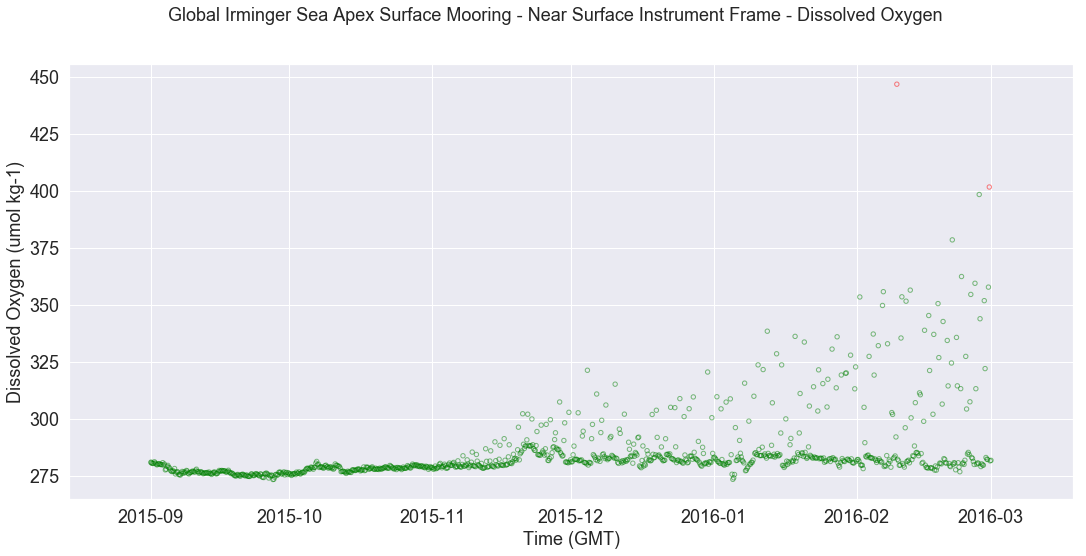

In [31]:
fig, axarr = plt.subplots(figsize=(18,8))

axarr.scatter(time, oxygen, color=colors, marker='o', alpha=0.5, s=19, facecolors='none')
             
fig.suptitle('Global Irminger Sea Apex Surface Mooring - Near Surface Instrument Frame - Dissolved Oxygen', fontsize=18)
axarr.set_ylabel('Dissolved Oxygen (umol kg-1)', fontsize = 18)
axarr.set_xlabel('Time (GMT)', fontsize = 18)
plt.setp(axarr.yaxis.get_majorticklabels(), size = 18)
plt.setp(axarr.xaxis.get_majorticklabels(), size = 18);


Import annotations for 'GI01SUMO-RID16-06-DOSTAD000'. See the request_annotations.ipynb notebook for more details.

In [32]:
import netCDF4 as nc

In [33]:
beginDT = int(nc.date2num(datetime.datetime.strptime("2012-01-01T01:00:01Z",'%Y-%m-%dT%H:%M:%SZ'),'seconds since 1970-01-01')*1000)
endDT = int(nc.date2num(datetime.datetime.utcnow(),'seconds since 1970-01-01')*1000)

anno_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find?' # base url and port for annotations

params = { # define parameters
    'beginDT':beginDT,
    'endDT':endDT,
    'refdes':'GI01SUMO-RID16-06-DOSTAD000'
}

r = requests.get(anno_base_url, params=params,auth=(username, token)) # send request for annotations

anno_data = pd.read_json(json.dumps(r.json())) # convert json response to pandas dataframe

Set up a function to convert the annotation milliseconds since 1970, which is a different time schema than is used for data, which is in seconds since 1900.

In [34]:
def convert_time(time_stamp):
    try: 
        time_stamp = (int(time_stamp)) / 1000
        time_stamp = nc.num2date(time_stamp,'seconds since 1970-01-01')
    except:
        pass
    return time_stamp

# convert time stamps
anno_data['beginDT'] = anno_data['beginDT'].apply(convert_time)
anno_data['endDT'] = anno_data['endDT'].apply(convert_time)

Print the annotations.

In [35]:
for i in range(len((anno_data['annotation'].values))):
    print(i)
    print(anno_data['annotation'].iloc[i])
    print('start time:', anno_data['beginDT'].iloc[i])
    print('end time:', anno_data['endDT'].iloc[i],'\n')

0
Deployment 1: Status data sent from the buoy included leak detects in the buoy well, drop in battery voltage, and loss of wind turbine input. Upon recovery, the buoy was primarily intact but several instruments were damaged and/or missing. Ice build-up on the tower is speculated to be the cause for much of the damage. No telemetered or recovered_host data expected. Functional instruments could continue to collect data using internal battery power and storage cards.
('start time:', Timestamp('2015-02-15 00:00:00'))
('end time:', Timestamp('2015-08-22 00:00:00'), '\n')
1
Deployment 2: A period of violent weather caused power outages on multiple instruments. No telemetered or recovered_host data expected. Functional instruments could continue to collect data using internal battery power and storage cards. Upon recovery, the buoy well was flooded.
('start time:', Timestamp('2016-01-27 00:00:00'))
('end time:', Timestamp('2016-07-19 00:00:00'), '\n')
2
Deployment 3: Wind turbines were dis

Select information from the fourth annotation and create the final plot.

In [98]:
from textwrap import wrap

In [115]:
anno_start_time = anno_data['beginDT'].iloc[4]
anno = anno_data['annotation'].iloc[4]
label_text ='Annotation: '+anno

labels = '\n'.join(wrap(label_text, 120))
labels

u'Annotation: Deployment 4: at 10:03 UTC on 12 October 2017 the Irminger Sea Surface Mooring stopped all communications.\nAt recovery, the surface buoy was missing. The subsurface portion of the mooring had fallen to the seafloor and was\nrecovered. CTDMOs, CTDBP-F, DOSTA, and ADCP instrumentation were full ocean depth rated and survived, although any\nrecovered data available after 2017-10-12T10:03:00 are suspect. All other instrumentation imploded or flooded. The cause\nfor the loss of the buoy is inconclusive.'

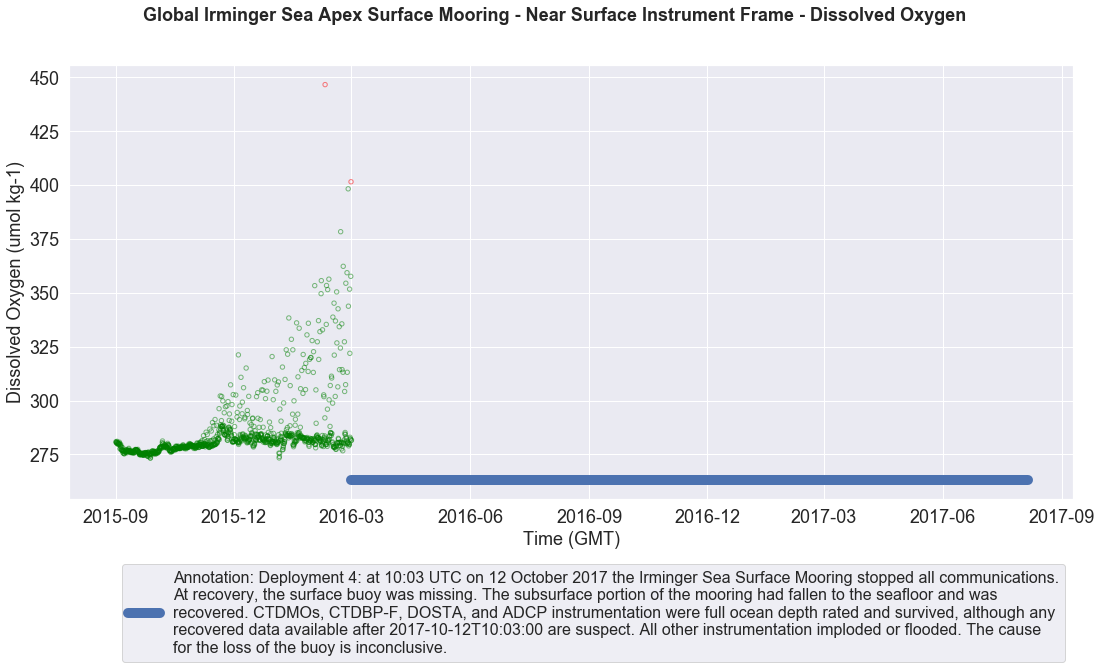

In [116]:
fig, axarr = plt.subplots(figsize=(18,8))

lines = axarr.plot([anno_start_time,time[-1]], [(min(oxygen)-10),(min(oxygen)-10)], linewidth=10)
axarr.scatter(time, oxygen, color=colors, marker='o', alpha=0.5, s=19, facecolors='none')
             
fig.suptitle('Global Irminger Sea Apex Surface Mooring - Near Surface Instrument Frame - Dissolved Oxygen', fontsize=18, fontweight='bold')
axarr.set_ylabel('Dissolved Oxygen (umol kg-1)', fontsize = 18)
axarr.set_xlabel('Time (GMT)', fontsize = 18)
plt.legend((lines),[labels], bbox_to_anchor=(1, -0.13), fontsize=16) #loc='upper right'
plt.setp(axarr.yaxis.get_majorticklabels(), size = 18)
plt.setp(axarr.xaxis.get_majorticklabels(), size = 18);

Optionally, you can save the plot as an html file for sharing.

In [111]:
output_file(os.getcwd())
save(p, filename='plot.html')

'/Users/leila/Documents/OOI_GitHub_repo/repos/2018-data-workshops/geology/examples/extras/plot.html'

This example was developed by Friedrich Knuth.